In [32]:
import numpy as np
import pandas as pd
import io
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
#import pandas_profiling

In [33]:
import sqlcl

In [34]:
# http://cas.sdss.org/dr15/en/tools/places/abell.aspx
#             Right Acension (ra),  Declination (dec)
# ra dec definition http://voyages.sdss.org/preflight/locating-objects/ra-dec/#:~:text=Computers%20and%20RA%20and%20Dec%20The%20Sloan%20Digital,The%20database%20is%20stored%20and%20accessed%20by%20computers.
# Abell 168   18.837, 0.26
# Abell 2255  258.1212,64.09654
# ABELL 1387  177.19526,51.61638
# ABELL 2197  247.04807,40.89878
# ABELL 2255  258.1212,64.09654
# ABELL 0958  153.378,-0.85,9

In [35]:
#lines = sqlcl.query("select g.objid, g.ra, g.dec, g.u, g.g, g.r, g.i, g.z from galaxy g, dbo.fGetNearbyObjEq(18.837,0.26,5) n where g.objid = n.objid").read()
lines = sqlcl.query("SELECT p.objID, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z FROM photoObj p JOIN dbo.fGetNearbyObjEq(153.378,-0.85,9) n ON n.objID = p.objID WHERE p.r BETWEEN 13 and 18 and p.g-p.r BETWEEN 0.6 and 1").read()
#lines = sqlcl.query("select g.objid, g.ra, g.dec, g.u, g.g, g.r, g.i, g.z from galaxy g, dbo.fGetNearbyObjEq(258.1212,64.09654,5) n where g.objid = n.objid").read()
print (len(lines))

6655


In [36]:
strA = lines.decode("utf-8")

In [37]:
#dump created string of Sloan Digital Sky Survey (SDSS) Data
#print (strA)

In [38]:
file = StringIO(strA)

In [39]:
# create DataFrame of our SDSS Data
df = pd.read_csv(file, skiprows=1)

In [40]:
#print (df)

In [41]:
# read in our Kaggle training data
dz = pd.read_csv("C:\Sky Server Kaggle Dataset\Skyserver_SQL2_27_2018 6_51_39 PM.csv\Skyserver_SQL2_27_2018 6_51_39 PM.csv")

In [42]:
#dummp Kaggle Data Set
#print (dz)

In [43]:
# determine unique rows in each column
dz.nunique().to_frame().transpose()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1,10000,10000,9730,9817,9852,9890,9896,23,1,6,703,6349,3,9637,487,355,892


In [44]:
# print out number of Galaxie, Stars, Quasors in our Kaggle Data Set
occurrences = dz['class'].value_counts().to_frame().rename(index=str, columns={'class': 'Occurrences'})
print (occurrences)

        Occurrences
GALAXY         4998
STAR           4152
QSO             850


In [45]:
# dump column headers of Kaggle Dataset
dz.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [46]:
# split data into input and target variable(s)

X = dz.drop("class", axis=1).drop("redshift", axis=1).drop("plate", axis=1).drop("specobjid", axis=1).drop("mjd", axis=1).drop("fiberid", axis=1).drop("field", axis=1).drop("run", axis=1).drop("camcol", axis=1).drop("rerun", axis=1)
y = dz["class"]

In [47]:
# standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [48]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.50, random_state=42
)

In [49]:
# create the classifier
classifier = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf = classifier.fit(X_train, y_train)


In [50]:
# review Decision Tree
#clf.estimators_

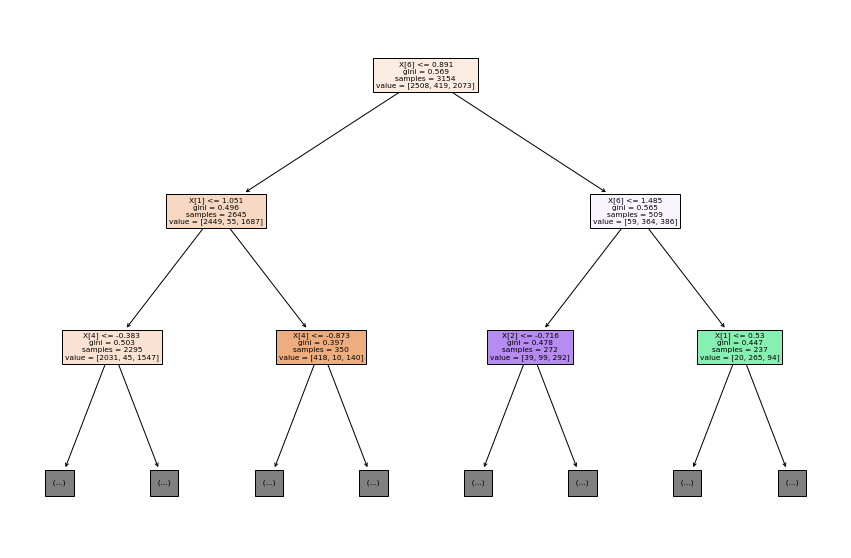

In [51]:
# plot decision tree
plt.figure(figsize=(15,10))
for i in range(len(clf.estimators_)) :
    tree.plot_tree(clf.estimators_[i], max_depth=2, filled=True)

In [52]:
# prediction on the test set
y_pred = clf.predict(X_test)
#print (y_pred)

Accuracy:  0.9066


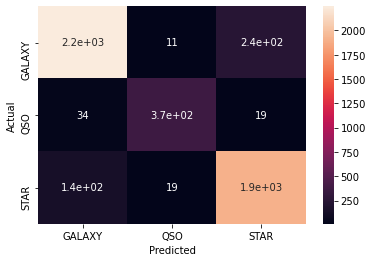

In [53]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
accscore = accuracy_score(y_test, y_pred)
print('Accuracy: ',accscore)
plt.show()

In [54]:
# check Important features
feature_importances_df = pd.DataFrame(
    {"feature": list(X.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

# Display Feater in order of Importance
feature_importances_df

,feature,importance
7,z,0.243900
5,r,0.167678
6,i,0.161691
3,u,0.158847
4,g,0.155639
1,ra,0.056477
2,dec,0.055769
0,objid,0.000000


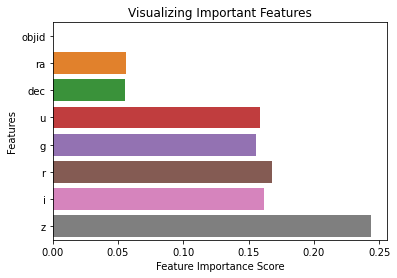

In [55]:
# plot importance (Visualization)
feature_imp = pd.Series(classifier.feature_importances_, index=X.columns)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.legend
plt.show()

In [56]:
# print out Score of identifying Galaxy, Quasar, Star
from sklearn.metrics import accuracy_score, f1_score
sortedlabels = clf.classes_
accscore = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred, average = None)
print(accscore)
for i in range(3):
    print((sortedlabels[i],f1score[i]), end=" ")


0.9066
('GALAXY', 0.9128580134064596) ('QSO', 0.8996372430471583) ('STAR', 0.9007058823529411) 

In [57]:
# Now work on our Abell Dataset
# standardize the Abell Dataset
scaler = StandardScaler()
X_scaled_New = scaler.fit_transform(df)
# use classifier model on Abell DataSet
y_new = clf.predict(X_scaled_New)
print (len(y_new))

66


In [58]:
#dump our classification of the Abell Dataset
#print (y_new)

In [59]:
#dump our Abell Dataset
#print (df)

In [60]:
# combine Abell view with assigned class (GALAXY, STAR, QSO)
x = df
x['class'] = y_new
# dump our Abell Dataset with classifications
#print(x)

In [61]:
def highlight_class(val):
    if val == "GALAXY":
        color = 'orange'
    elif val == "STAR":
        color = 'blue'
    elif val == "QSO":
        color = 'red'
    return 'background-color: %s' % color


In [62]:
x.style.applymap(highlight_class, subset=['class'])

,objID,ra,dec,u,g,r,i,z,class
0,1237648720145285165,153.290222,-0.968550,19.471990,17.426910,16.612830,16.179210,15.871900,GALAXY
1,1237648720145350668,153.379288,-0.946914,19.488990,17.414420,16.531510,16.097220,15.762930,GALAXY
2,1237648720145350669,153.370343,-0.923081,18.863960,16.823160,15.967610,15.551380,15.218920,GALAXY
3,1237648720145350673,153.445049,-0.914262,20.590980,18.278610,17.426780,16.878260,16.561440,GALAXY
4,1237648720145350674,153.426076,-0.907198,19.150830,17.248230,16.426470,16.026540,15.746050,GALAXY
5,1237648720145350675,153.422948,-0.922294,19.410160,17.558010,16.687400,16.280560,15.985190,GALAXY
6,1237648720145350676,153.431427,-0.918326,24.634680,18.712800,17.917970,18.387100,22.826910,STAR
7,1237648720145350680,153.428356,-0.936943,19.173950,17.256430,16.457060,16.082620,15.892450,GALAXY
8,1237648720145350687,153.373011,-0.924363,24.918390,18.549270,17.754870,17.346700,23.250880,STAR
9,1237648720145350691,153.427712,-0.962940,19.377120,18.506640,17.700990,17.318100,17.026220,QSO
